# Calculating hydromagnetic modes & their angular momentum 

We set up the eigen problem for the dissipation/diffusionless MHD equations

$$
\frac{\partial\mathbf{u}}{\partial t} = -\frac{2}{Le}\mathbf{e}_\Omega\times\mathbf{u} + \left(\nabla\times\mathbf{b}_0\right)\times\mathbf{b}+ \left(\nabla\times\mathbf{b}\right)\times\mathbf{b}_0,\\
\frac{\partial\mathbf{b}}{\partial t} =\nabla\times\left(\vec{u}\times\mathbf{b}_0\right).
$$

We only consider $\mathbf{e}_\Omega=\mathbf{e}_z$ for comparison, arbitrary orientation is possible.

The truncating monomial degree is `N`.

We investigate the sphere first, followed by an ellipsoid with $a=2,b=1/2,c=1$.

### Setup

Including packages, first time, if not already installed, run in the Julia REPL : `]add https://github.com/fgerick/Mire.jl.git PyPlot GenericSchur`

In [1]:
using Mire, PyPlot, GenericSchur

# Sphere

### Parameter setup

To have very high accuracy in the eigen solution and integration, we need to use arbitrary precision. In Julia this is called `BigFloat`. 

In [2]:
b1=one(BigFloat)

1.0

In [3]:
a,b,c=b1,b1,b1
Le = big"1e-6"
Ω = 1/Le * ez #given as vector
N = 5
α = big"0.1";

Mean field using A-formulation (for the spherical case only), following
$$
\bar{A} = \frac{H^3}{3}\left(1-\alpha x^2\right)
$$

In [4]:
function B0_A(α)
    BM0 = [-y,x,0] #malkus field
    BA = [-3x^2*y,5*x^3+2x*y^2-2x,2x*y*z]/3b1
    return BM0-α*BA
end 

B0_A (generic function with 1 method)

Mean field using uniform currents (Vidal, 2018 eq. 5.15)

In [5]:
function B0_uni(α,a,b)
    BM0 = [-y/b^2,x/a^2,0] #malkus field
    BA = [z/c^2,0,-x/a^2]
    return BM0-α*BA
end

B0_uni (generic function with 1 method)

### Assemble
Calculate left and right hand side sparse matrices `LHS,RHS` and the velocity base vectors `vs`. We use the uniform current mean magnetic field here, but this is easily varied.

In [6]:
LHS,RHS,vs = assemblemhd(N,a,b,c,Ω,B0_uni(α,a,b));

### Solve eigen problem
Use `GenericSchur` to solve the eigen problem. In case of `Float64` precision we could use the _much_ faster `LAPACK` function `eigen()` included in the `LinearAlgebra` standard library of Julia. Since the `schur` and `inv` function require dense matrices we convert the sparse matrices `LHS` to a dense one by `Matrix(LHS)`. Additionally, `schur` requires a complex matrix.

In [7]:
esol = schur(complex.(inv(Matrix(LHS))*RHS));
evals = esol.values;
evecs = eigvecs(esol);

In [8]:
nev = length(esol.values)

170

### Reconstruct velocity and magnetic field of individual modes

In [9]:
eigenvs = [eigenvel(N,vs,evecs[1:nev,:],i,a,b,c,norm=false) for i=1:nev];
eigenbs = [eigenvel(N,vs,evecs[nev÷2+1:end,:],i,a,b,c,norm=false) for i=1:nev];

### Calculate and plot angular momenta of all modes

In [10]:
L = angularmom.(eigenvs,a,b,c);

We also calculate the kinetic and magnetic energy, as well as their ratio.

In [11]:
Ekin = abs.([Mire.inner_product(eigenvs[i],eigenvs[i],a,b,c) for i=1:nev])
Emag = abs.([Mire.inner_product(eigenbs[i],eigenbs[i],a,b,c) for i=1:nev])
ratio = Ekin./Emag;

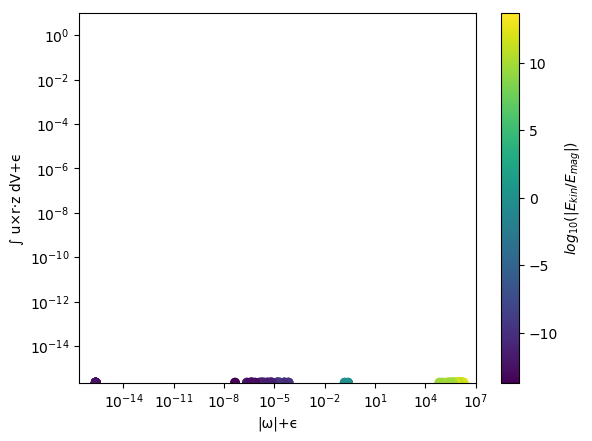

In [12]:
scatter(abs.(esol.values).+eps(),abs.(L).+eps(),c=log10.(ratio))
xscale("log")
yscale("log")
ylim([eps(),10.])
xlim([eps()/10,10/Float64.(Le)])
cb=colorbar()
cb[:set_label](L"log_{10}(|E_{kin}/E_{mag}|)")
clim([-maximum(log10.(ratio)),maximum(log10.(ratio))])
xlabel("|ω|+ϵ")
ylabel("∫ u×r⋅z dV+ϵ");

# Ellipsoid

In [13]:
a_e,b_e,c_e=2b1,b1/2,b1

(2.0, 0.50, 1.0)

In [14]:
LHS_e,RHS_e,vs_e = assemblemhd(N,a_e,b_e,c_e,Ω,B0_uni(α,a_e,b_e));

In [15]:
esol_e = schur(complex.(inv(Matrix(LHS_e))*RHS_e));
evals_e = esol_e.values;
evecs_e = eigvecs(esol_e);

In [16]:
eigenvs_e = [eigenvel(N,vs_e,evecs_e[1:nev,:],i,a_e,b_e,c_e,norm=false) for i=1:nev];
eigenbs_e = [eigenvel(N,vs_e,evecs_e[nev÷2+1:end,:],i,a_e,b_e,c_e,norm=false) for i=1:nev];

In [17]:
L_e = angularmom.(eigenvs_e,a_e,b_e,c_e);

In [18]:
Ekin_e = abs.([Mire.inner_product(eigenvs_e[i],eigenvs_e[i],a_e,b_e,c_e) for i=1:nev])
Emag_e = abs.([Mire.inner_product(eigenbs_e[i],eigenbs_e[i],a_e,b_e,c_e) for i=1:nev])
ratio_e = Ekin_e./Emag_e;

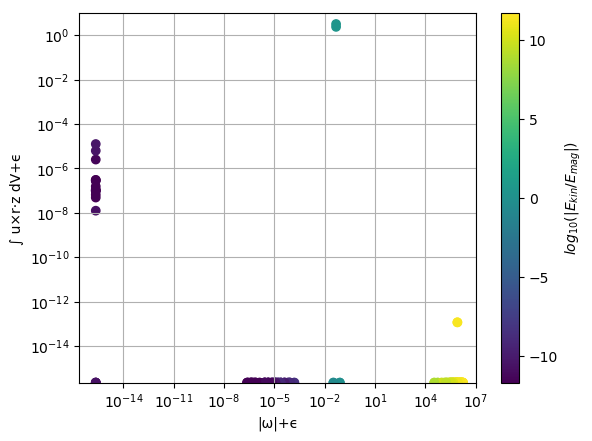

In [19]:
scatter(abs.(evals_e).+eps(),abs.(L_e).+eps(),c=log10.(ratio_e))
xscale("log")
yscale("log")
ylim([eps(),10.])
xlim([eps()/10,10/Float64.(Le)])
cb=colorbar()
cb[:set_label](L"log_{10}(|E_{kin}/E_{mag}|)")
clim([-maximum(log10.(ratio_e)),maximum(log10.(ratio_e))])
xlabel("|ω|+ϵ")
ylabel("∫ u×r⋅z dV+ϵ")
grid();

### What does the torsional mode carrying angular momentum look like?
Select the modes:

In [20]:
torsionals=eachindex(evals_e)[(1e-2.<abs.(evals_e).<10.) .& (abs.(L_e).>1e-3)];

In [21]:
function __mgrid(x::AbstractVector{T},y::AbstractVector{T}) where T<: Real
    X = [i for j in y, i in x]
    Y = [j for j in y, i in x]
    return X,Y
end

function plot_velocity_equator_uphi(a,b,v1; ngrid=50, kwargs...)

    X, Y = __mgrid(range(-a,stop=a,length=ngrid),range(-b,stop=b,length=ngrid))
    ux =  real.([v1[1](x=>xt,y=>yt,z=>0) for (xt,yt) in zip(X,Y)])
    uy =  real.([v1[2](x=>xt,y=>yt,z=>0) for (xt,yt) in zip(X,Y)])
    radius = .√(X.^2/a^2+Y.^2/b^2)
    u = .√(ux.^2+uy.^2)
    phi = atan.(Y,X);
    uphi =( -b*sin.(phi).*ux .+ a*cos.(phi).*uy) #./radius;
    
    outsideellipse=(X.^2/a^2+Y.^2/b^2).>=1.
    ux[outsideellipse].=0.
    uy[outsideellipse].=0.
    uphi[outsideellipse].=0.
    uphio = copy(uphi)
    
    uphi.-=maximum(uphi)
    
    sp = streamplot(Float64.(X), Float64.(Y), Float64.(ux), Float64.(uy) ; color=Float64.(uphi), kwargs...) # linewidth=3*u/maximum(u), kwargs...)

    uphimax = maximum(abs.(uphi))
    
    ellipsex=a*cos.(range(0,stop=2π,length=100))
    ellipsey=b*sin.(range(0,stop=2π,length=100))
    plot(ellipsex,ellipsey,"k",linewidth=1)
    axis("equal")
    axis("off");
end

plot_velocity_equator_uphi (generic function with 1 method)

### Equatorial sections
Color indicates azimuthal component

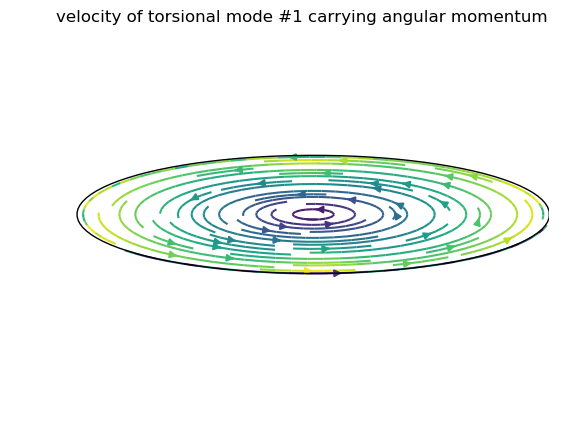

In [22]:
plot_velocity_equator_uphi(a_e,b_e, eigenvs_e[torsionals[1]]); title("velocity of torsional mode #1 carrying angular momentum");

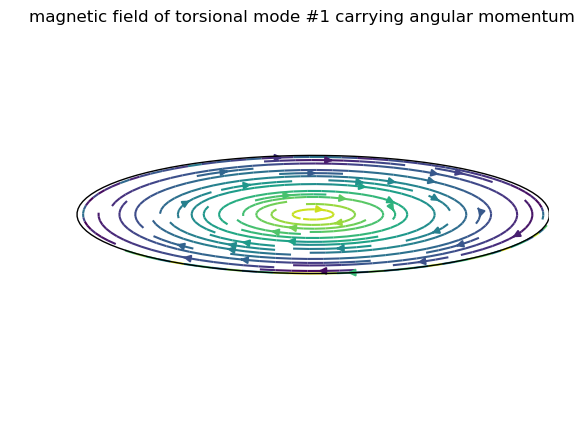

In [23]:
plot_velocity_equator_uphi(a_e,b_e, eigenbs_e[torsionals[1]]); title("magnetic field of torsional mode #1 carrying angular momentum");

### What about the torsional modes not carrying angular momentum?

In [24]:
torsionals_nL=eachindex(evals_e)[(1e-2.<abs.(evals_e).<10.) .& (abs.(L_e).<1e-3)];

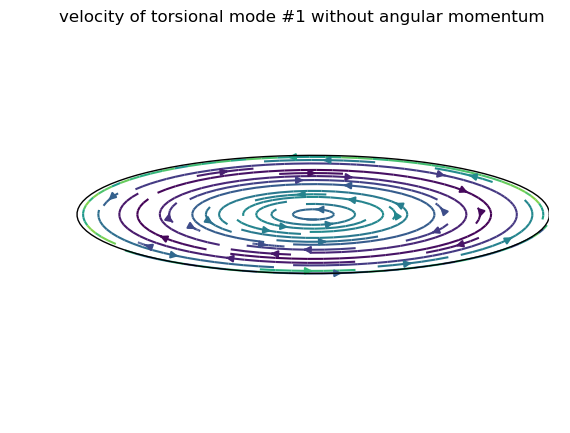

In [25]:
plot_velocity_equator_uphi(a_e,b_e, eigenvs_e[torsionals_nL[1]]); title("velocity of torsional mode #1 without angular momentum");

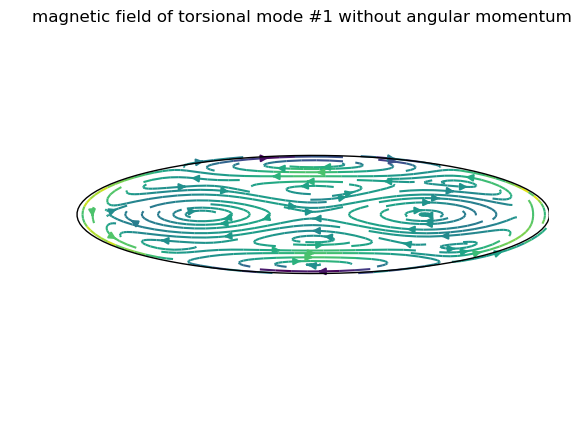

In [26]:
plot_velocity_equator_uphi(a_e,b_e, eigenbs_e[torsionals_nL[1]]); title("magnetic field of torsional mode #1 without angular momentum");

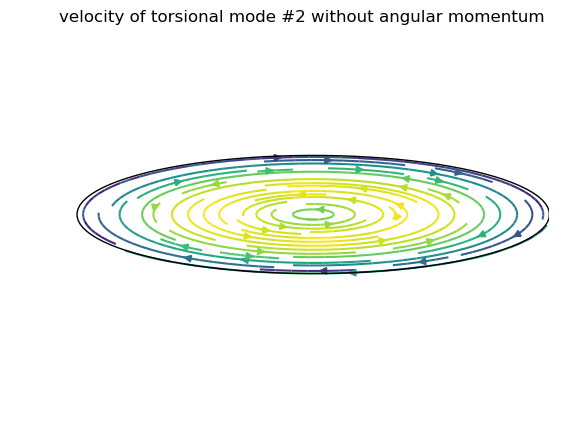

In [27]:
plot_velocity_equator_uphi(a_e,b_e, eigenvs_e[torsionals_nL[3]]); title("velocity of torsional mode #2 without angular momentum");

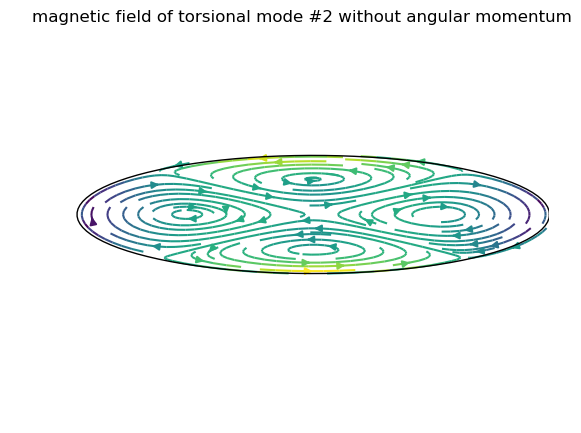

In [28]:
plot_velocity_equator_uphi(a_e,b_e, eigenbs_e[torsionals_nL[3]]); title("magnetic field of torsional mode #2 without angular momentum");